<a href="https://colab.research.google.com/github/mdpetrov/pref-ai/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detection of anomalies and fraudlent activity in binary options trading data

In this analysis I did an investigation in binary options trading transactions in order to find anomalies and fraudlent activity. First I started with formulating a brief plan of what I'm going to do:
1. **Exploratory data analysis.** I estimated basic statistics and graphics in order to better understand the data, get some insights and make several hypothesis about factors that could help me to detect anomalies in traders behaviour.
2. **Traders profile invetigation.** I made a profile of each trader based on information about their transactions



## Loading packeges and reading the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
import datetime
import gc

In [2]:
trades = pd.read_csv('/content/drive/MyDrive/quadcode_2023_test/data/AntiFraudAnalystTradeData.csv')
print(trades.shape)
trades.head()

(1764494, 17)


,Unnamed: 0,id,user_id,registration_date,fin_instrument,instrument_type,instrument_direction,create_at,close_at,instrument_expiration,close_reason,platform,open_quote,close_quote,instrument_strike,initial_investment_enrolled,pnl_total_enrolled
0,0,9653594472,585118157,2019-04-05 17:12:46.000000,XRPUSD,turbo-option,call,2022-06-17 19:41:03.216000+00:00,2022-06-17 19:42:00+00:00,2022-06-17 19:42:00+00:00,expired,Unknown platform,0.314705,0.314955,0.314705,22.610000,19.210000
1,1,9641975390,1456695825,2021-08-12 02:28:57.928101,XRPUSD,turbo-option,call,2022-06-14 00:23:15.137000+00:00,2022-06-14 00:24:00+00:00,2022-06-14 00:24:00+00:00,expired,WebGL,0.308125,0.307895,0.308125,0.390000,-0.390000
2,2,15634194734,220188644,2017-03-25 01:22:50.000000,XRPUSD,digital-option,call,2022-06-13 20:18:13.091000+00:00,2022-06-13 20:19:00+00:00,2022-06-13 20:19:00+00:00,expired,WinGL,0.323725,0.323695,0.323725,0.391288,-0.391288
3,3,15639824168,1722200363,2022-06-14 21:47:25.600786,ETHUSD,digital-option,put,2022-06-14 20:17:00.316000+00:00,2022-06-14 20:18:00+00:00,2022-06-14 20:18:00+00:00,expired,WebGL,1205.656500,1203.599000,1205.656500,3.900220,3.704580
4,4,9642044367,984111245,2020-07-29 22:30:11.776766,BTCUSD,turbo-option,call,2022-06-14 00:50:41.887000+00:00,2022-06-14 00:52:00+00:00,2022-06-14 00:52:00+00:00,expired,WinGL,22227.305000,22185.852000,22227.305000,0.390000,-0.390000


In [21]:
trades.columns

Index(['Unnamed: 0', 'id', 'user_id', 'registration_date', 'fin_instrument',
       'instrument_type', 'instrument_direction', 'create_at', 'close_at',
       'instrument_expiration', 'close_reason', 'platform', 'open_quote',
       'close_quote', 'instrument_strike', 'initial_investment_enrolled',
       'pnl_total_enrolled'],
      dtype='object')

In [57]:
devices = pd.read_csv('/content/drive/MyDrive/quadcode_2023_test/data/AntiFraudAnalystUserDevices.csv')
print(devices.shape)
devices.head()

(6245842, 3)


,Unnamed: 0,user_id,device_id
0,0,1185175017,a3037561a43a726fdbd4168b4e2e7df7
1,1,1245468614,92e5e634-9d56-4aa9-9dd3-9cca03da117e
2,2,698383907,fdc12321-6bfc-4647-9bc8-fd8afb2ea519
3,3,597374921,96cdb18c-c2cd-4485-a9be-eb24ac5a7d70
4,4,1573954525,382cfedb2d3dcc74bb7b1aab54d6f26f


## Transactions exploratory data analysis
First, I took a look at several features that gave me a basic

For now I'm only investigating on transactions, I'll look at devices later when I'll come to users

### Dates

Text(0.5, 1.0, 'Trades count based on date')

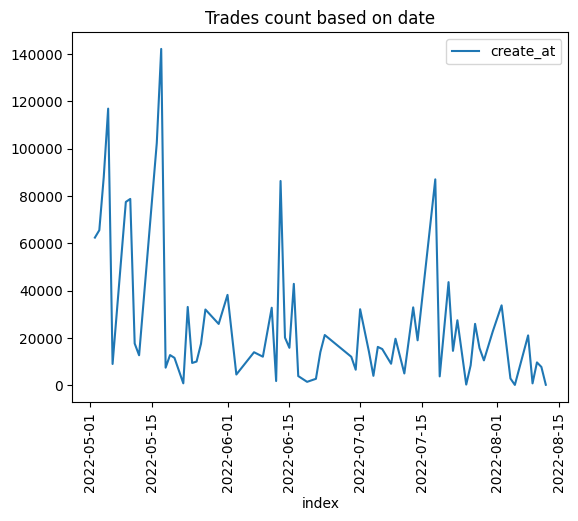

In [12]:
trades['create_at'].astype('datetime64').dt.date.value_counts().reset_index().plot(x='index', y='create_at')
plt.xticks(rotation=90)
plt.title('Trades amount based on date')

So, I have transactions from 01.05.2022 to 15.08.2022. As I could see there are some spikes on the graph that could possible mean either new clients coming our platform or old clients returning to us. It order to understand this I made another graph

Text(0.5, 1.0, 'Users registrations per day')

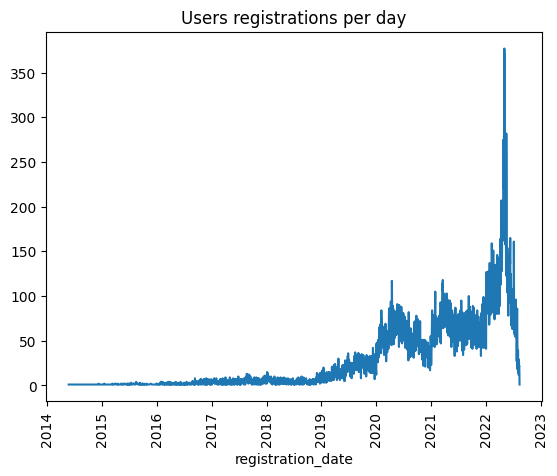

In [14]:
tmp = pd.DataFrame(trades['registration_date'].astype('datetime64').dt.date, index=trades.index)
tmp['user_id'] = trades['user_id']
tmp.groupby('registration_date')['user_id'].agg(pd.Series.nunique).plot(x='index', y='user_id')
plt.xticks(rotation=90)
plt.title('Users registrations per day')

Text(0.5, 1.0, 'Users activity (transaction count) depending on registration date')

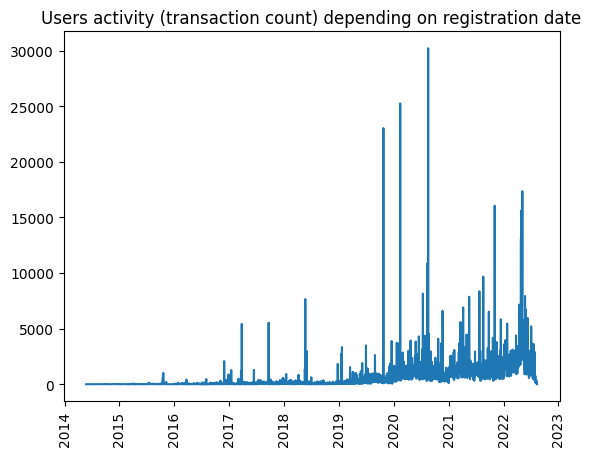

In [18]:
tmp = pd.DataFrame(trades['registration_date'].astype('datetime64').dt.date, index=trades.index)
tmp['registration_date'].value_counts().plot()
plt.xticks(rotation=90)
plt.title('Users activity (transaction count) depending on registration date')

As I can see the amount of user registrations per day was pretty flat until 2020 year. Then it started to grow in 2020, 2021 and got to the top of 350 users per day in 2022 after whet it started to move down.

### String variables

<Figure size 640x480 with 0 Axes>

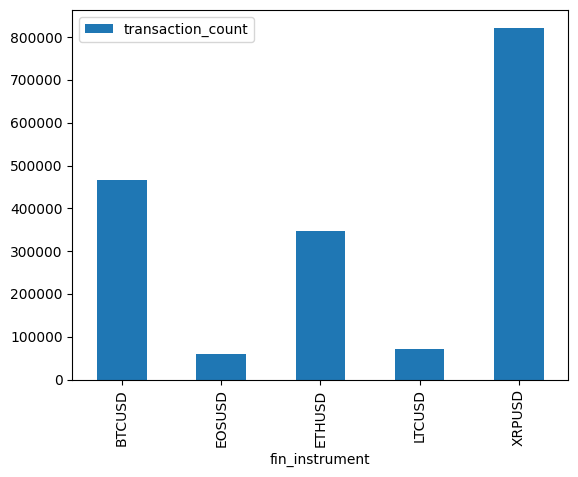

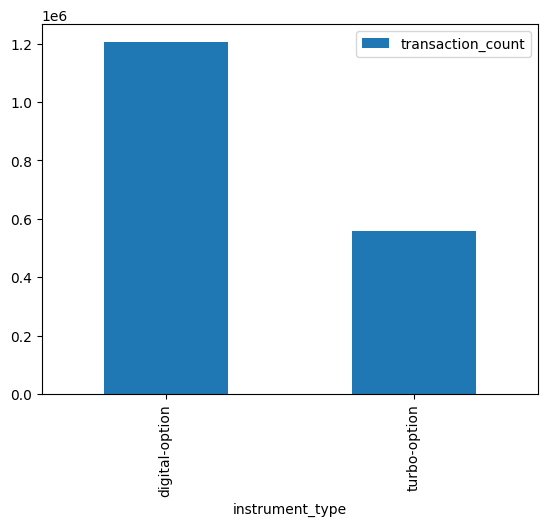

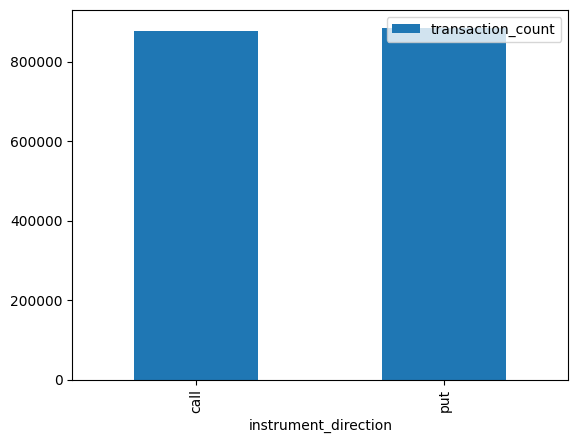

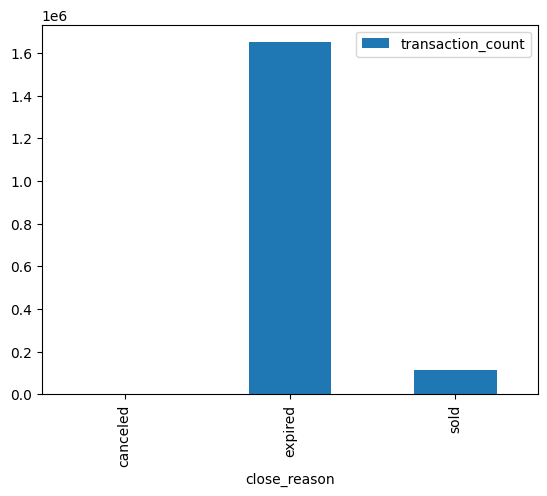

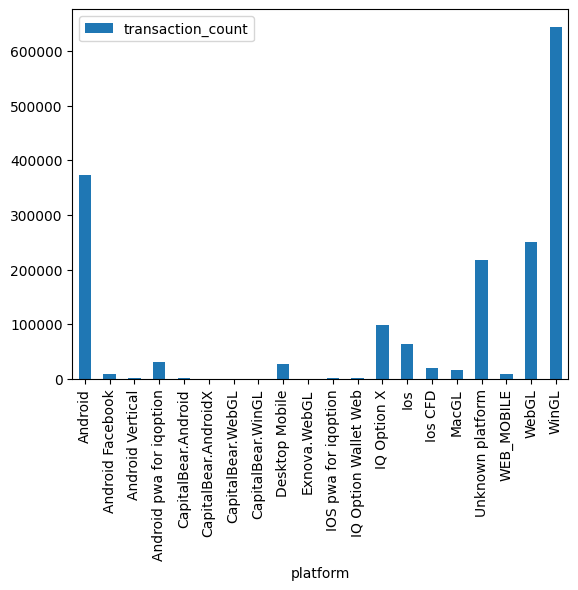

In [54]:
plt.clf()
# fig, ax = plt.subplots(2,3, figsize=(10,10))
# ax = ax.reshape(-1)
for i,v in enumerate(['fin_instrument', 'instrument_type', 'instrument_direction', 'close_reason', 'platform']):
    trades.groupby(v, as_index=False)[['id']].count().rename(columns={'id':'transaction_count'}).plot(kind='bar', x=v, y='transaction_count')
    # ax[i].bar(x=dg[v], height=dg['transaction_count'])
    # ax[i].set_title(v)
    # ax[i].set_xticklabels(dg[v], rotation = 90)
plt.show()

As I could see from the graphs above the most popular instrument is XRPUSD. Type of the instrument is generally digital option. The option direction statistics is equal between put and call. Close reason is mainly option expiration. And top platforms are WinGL, Android and WebGL

Then I looked at finance variables: investments and profit/loss

### Values

In [56]:
for v in ['initial_investment_enrolled', 'pnl_total_enrolled']:
    print(trades[v].quantile([x/10 for x in range(11)]))

0.0       0.360000
0.1       0.390402
0.2       0.406486
0.3       0.626225
0.4       0.980000
0.5       1.056545
0.6       1.948860
0.7       2.900000
0.8       5.000000
0.9      13.490000
1.0    1608.910000
Name: initial_investment_enrolled, dtype: float64
0.0   -1558.320000
0.1      -4.226257
0.2      -1.740000
0.3      -0.813964
0.4      -0.395178
0.5       0.320000
0.6       0.387469
0.7       0.881636
0.8       1.771030
0.9       5.126098
1.0    1544.560000
Name: pnl_total_enrolled, dtype: float64


Here we could already see outliers. The majority of trades has investment amount of no more than \~1\$ and the return is no more than 0.32\$. Also I mentioned huge maximum value of investments and both maximum and minimum values of profit. I should definetely look at these cases.

## Traders profiles analysis
After transactions EDA I decided to search for anomalies in traders behaviour during current period. First of all I generated new features and transform string variables to dummies in order to put them into
models later.


### New features

In [58]:
trades['trade_duration'] = (trades.close_at.astype('datetime64[ns]') - trades.create_at.astype('datetime64[ns]')).dt.total_seconds()
trades['option_duration'] = (trades.instrument_expiration.astype('datetime64[ns]') - trades.create_at.astype('datetime64[ns]')).dt.total_seconds()
trades['positive_pnl'] = 1*(trades['pnl_total_enrolled'] > 0)
trades['profitability'] = trades['pnl_total_enrolled'] / trades['initial_investment_enrolled']
for v in ['fin_instrument', 'instrument_type', 'instrument_direction', 'close_reason', 'platform']:
    tmp = pd.get_dummies(trades[v], prefix=v)
    trades[tmp.columns] = tmp

trades['create_at'] = trades['create_at'].astype('datetime64[ns]')
trades['create_at_dt'] = trades['create_at'].dt.date
trades.sort_values(['user_id', 'create_at'], inplace=True)
trades['trade_freq'] = trades.groupby('user_id')['create_at'].diff(1).dt.total_seconds()

trades.columns

Index(['Unnamed: 0', 'id', 'user_id', 'registration_date', 'fin_instrument',
       'instrument_type', 'instrument_direction', 'create_at', 'close_at',
       'instrument_expiration', 'close_reason', 'platform', 'open_quote',
       'close_quote', 'instrument_strike', 'initial_investment_enrolled',
       'pnl_total_enrolled', 'trade_duration', 'option_duration',
       'positive_pnl', 'profitability', 'fin_instrument_BTCUSD',
       'fin_instrument_EOSUSD', 'fin_instrument_ETHUSD',
       'fin_instrument_LTCUSD', 'fin_instrument_XRPUSD',
       'instrument_type_digital-option', 'instrument_type_turbo-option',
       'instrument_direction_call', 'instrument_direction_put',
       'close_reason_canceled', 'close_reason_expired', 'close_reason_sold',
       'platform_Android', 'platform_Android Facebook',
       'platform_Android Vertical', 'platform_Android pwa for iqoption',
       'platform_CapitalBear.Android', 'platform_CapitalBear.AndroidX',
       'platform_CapitalBear.WebGL', 'pl

Here:

* trade_duration -- actual time of trader kept the option in seconds;
* option_duration -- maximum option duration in seconds;
* profitability -- ratio of profit (loss) to investment;
* trade_freq -- amount of time between previous transaction in seconds;

Other variables are technical and needed for future aggregation.

Next I'm going to aggregate all features and get on the user's level.



### User profile creation

In [60]:
res = {}
dg = trades.groupby('user_id')
res['registration_date'] = dg['registration_date'].max().astype('datetime64').dt.date
res['transaction_cnt'] = dg['id'].count()
res['pos_transaction_share'] = dg['positive_pnl'].sum() / res['transaction_cnt']
res['transactions_per_day'] = res['transaction_cnt'] / dg['create_at_dt'].agg(pd.Series.nunique)
res['fin_instrument_cnt'] = dg['fin_instrument'].agg(pd.Series.nunique)
for x in ['fin_instrument', 'instrument_type', 'instrument_direction', 'close_reason', 'platform']:
    columns = [x[0] for x in trades.columns.str.findall('{}_.*'.format(x)) if len(x) > 0]
    for v in columns[:-1]:
        res['{}_share'.format(v)] = dg[v].sum() / res['transaction_cnt']
res['trade_frequency_mean'] = dg['trade_freq'].mean()
res['trade_frequency_var'] = dg['trade_freq'].var()
res['trade_duration_mean'] = dg['trade_duration'].mean()
res['trade_duration_var'] = dg['trade_duration'].var()
res['option_duration_mean'] = dg['option_duration'].mean()
res['option_duration_var'] = dg['option_duration'].var()
res['investment_mean'] = dg['initial_investment_enrolled'].mean()
res['investment_var'] = dg['initial_investment_enrolled'].var()
res['investment_sum'] = dg['initial_investment_enrolled'].sum()
res['profit_mean'] = dg['pnl_total_enrolled'].mean()
res['profit_var'] = dg['pnl_total_enrolled'].var()
res['profit_sum'] = dg['pnl_total_enrolled'].sum()
res['profitability_mean'] = dg['profitability'].mean()
res['profitability_var'] = dg['profitability'].var()
res = pd.DataFrame(res)
users = res.copy()
users['device_cnt'] = devices.groupby('user_id')['device_id'].count()
users['registration_date'] = (users.registration_date - users.registration_date.min()).dt.total_seconds()
users.device_cnt.fillna(0, inplace=True)
users.trade_frequency_med.fillna(-1, inplace=True)

print(users.columns)
users.head()

Index(['registration_date', 'transaction_cnt', 'pos_transaction_share',
       'transactions_per_day', 'fin_instrument_cnt',
       'fin_instrument_BTCUSD_share', 'fin_instrument_EOSUSD_share',
       'fin_instrument_ETHUSD_share', 'fin_instrument_LTCUSD_share',
       'instrument_type_digital-option_share',
       'instrument_direction_call_share', 'close_reason_canceled_share',
       'close_reason_expired_share', 'platform_Android_share',
       'platform_Android Facebook_share', 'platform_Android Vertical_share',
       'platform_Android pwa for iqoption_share',
       'platform_CapitalBear.Android_share',
       'platform_CapitalBear.AndroidX_share',
       'platform_CapitalBear.WebGL_share', 'platform_CapitalBear.WinGL_share',
       'platform_Desktop Mobile_share', 'platform_Exnova.WebGL_share',
       'platform_IOS pwa for iqoption_share',
       'platform_IQ Option Wallet Web_share', 'platform_IQ Option X_share',
       'platform_Ios_share', 'platform_Ios CFD_share', 'platform

,registration_date,transaction_cnt,pos_transaction_share,transactions_per_day,fin_instrument_cnt,fin_instrument_BTCUSD_share,fin_instrument_EOSUSD_share,fin_instrument_ETHUSD_share,fin_instrument_LTCUSD_share,instrument_type_digital-option_share,...,option_duration_var,investment_mean,investment_var,investment_sum,profit_mean,profit_var,profit_sum,profitability_mean,profitability_var,device_cnt
user_id,,,,,,,,,,,,,,,,,,,,,
2352922,2014-05-24,2,0.5000,2.0,1,0.0,0.0,0.0,0.00,0.0,...,699.417401,0.790000,0.000000,1.58000,-0.050000,1.095200,-0.100000,-0.063291,1.754847,9.0
2850718,2014-06-27,3,0.0000,3.0,1,0.0,0.0,0.0,0.00,1.0,...,20549.323596,3.000000,0.000000,9.00000,-2.006172,2.963084,-6.018515,-0.668724,0.329232,149.0
3283384,2014-07-18,2,0.0000,2.0,1,1.0,0.0,0.0,0.00,0.0,...,1324.271648,1.000000,0.000000,2.00000,-1.000000,0.000000,-2.000000,-1.000000,0.000000,11.0
3726424,2014-08-05,4,0.5000,4.0,1,1.0,0.0,0.0,0.00,1.0,...,8779.500603,1.750000,0.250000,7.00000,-0.699661,2.336699,-2.798646,-0.230856,0.902772,64.0
3994731,2014-08-15,16,0.6875,8.0,2,0.0,0.0,0.0,0.25,1.0,...,330.646636,1.993539,0.822711,31.89662,0.668442,4.005635,10.695077,0.320789,0.845819,1.0


Here I aggregated all features I have and created a dataframe that contains all information on the user level including amount of devices user used. Because we don't have any information about device type or date when it was used, we could only look for count of it.